In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)
set.seed(1234)

# Heart Disease

# **Research Question:** How do a person’s health factors influence the likelihood of that person having a heart disease? 

# Introduction

Heart disease is a broad term for many heart conditions. A person can go undiagnosed for most of their life until they experience a major symptom such as a heart attack or even heart failure. Many personal health factors can affect their risk of having a heart disease. This includes, cholesterol, age, and sex.  
For this analysis, we will be using the UCI Machine Learning Repository's Heart Disease dataset. This dataset includes 14 variables, including age, sex, chest pain type, resting blood pressure, cholesterol level, fasting blood sugar, resting ekg results, maximum heart rate achieved, and exercise induced angina. There are datasets from four different hospitals, however the set from the Cleveland hospital appears to be the only fully processed set, and so it what will be used for this project. When analyzing this data it is intended to find what health factors can affect a person’s chance of having heart disease. 


In [4]:
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

#read and tidy the data
heart_disease <- read_csv(url, col_names=FALSE) %>%
    rename(age = X1,
            sex = X2,
          cp = X3,
          trestbps = X4,
          chol = X5,
          fbs = X6,
          restecg =X7,
          thalach = X8,
          exang =X9, 
          oldpeak =X10,
          slope =X11,
          ca = X12,
          thal = X13,
          num = X14) %>%
    mutate(num = as_factor(num))%>%
    filter(ca!='?')%>%
    filter(thal!='?')%>%
    mutate(ca=as.double(ca))%>%
    mutate(thal=as.double(thal))

heart_disease

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7,2
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1


The data from the Cleveland dataset is read in from the url, and rows with inelligible values of ca and thal are filtered out. The ca and thal columns are then redefined back into the correct data type (double). Next, a few exploratory data analyses are carried out. First, several different variables are compared in plots. As in the knn algorithm the data is normalized, these too were normalized for clearer visualization.

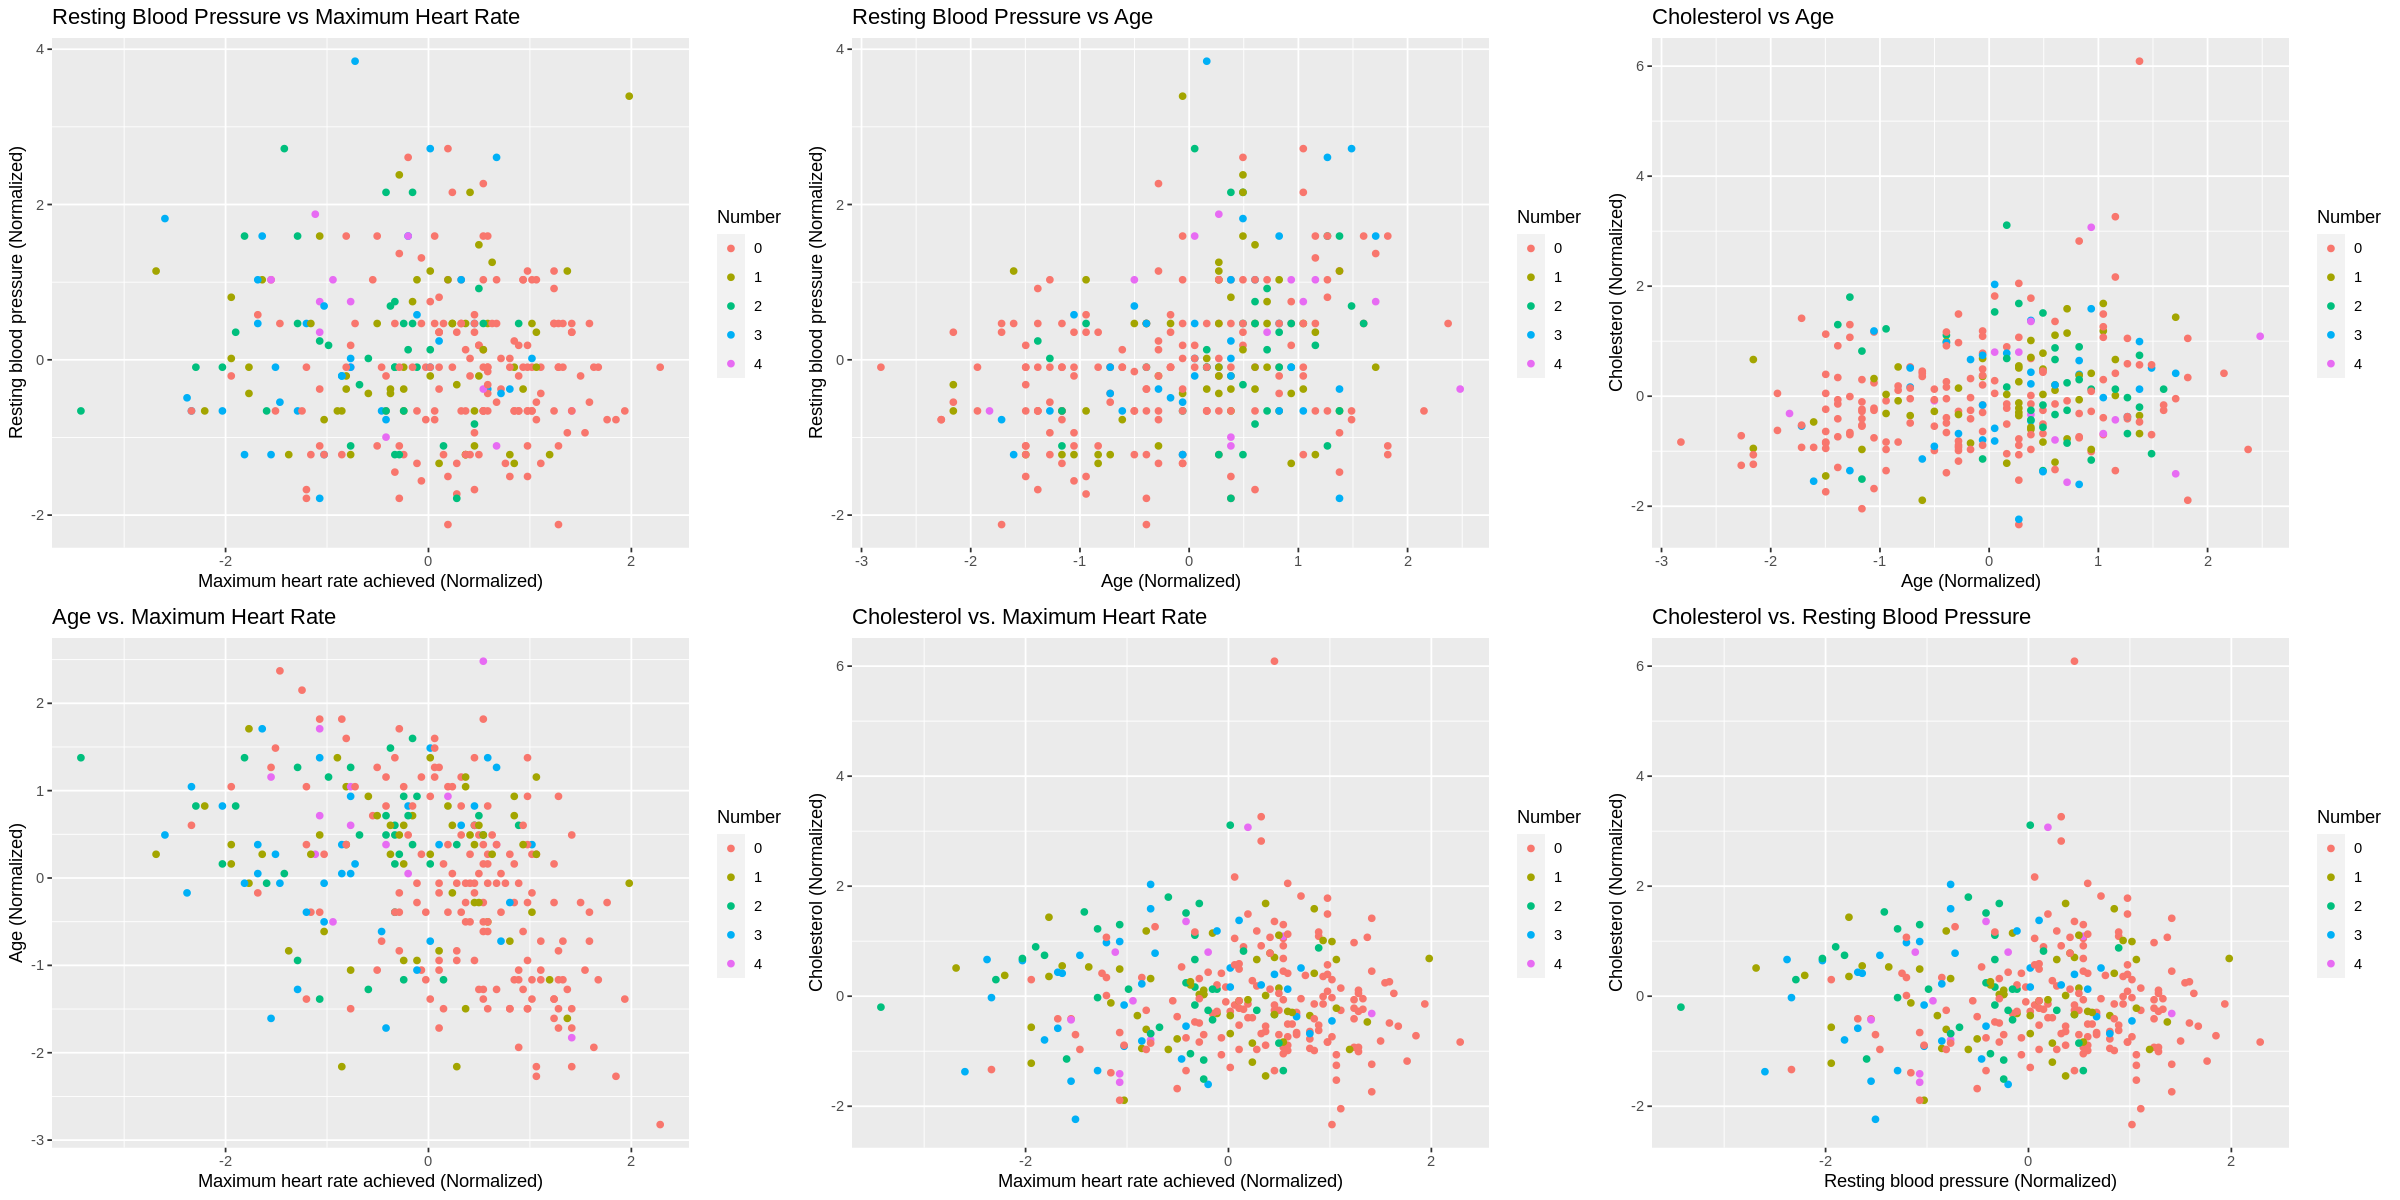

In [6]:
options(repr.plot.height = 10, repr.plot.width = 20)
scaled_heart_disease <- heart_disease %>% 
   mutate(across('age':'thal', scale))
exp_plot1<-ggplot(scaled_heart_disease,aes(x=thalach,y=trestbps,color=num)) +
           geom_point() +
           xlab('Maximum heart rate achieved (Normalized)') +
           ylab('Resting blood pressure (Normalized)') +
           labs(color='Number') +
           ggtitle('Resting Blood Pressure vs Maximum Heart Rate')

exp_plot2<-ggplot(scaled_heart_disease,aes(x=age,y=trestbps,color=num)) +
           geom_point() +
           xlab('Age (Normalized)') +
           ylab('Resting blood pressure (Normalized)')  +
           labs(color='Number') +
           ggtitle('Resting Blood Pressure vs Age')
exp_plot3<-ggplot(scaled_heart_disease,aes(x=age,y=chol,color=num)) +
           geom_point() +
           xlab('Age (Normalized)') +
           ylab('Cholesterol (Normalized)')  +
           labs(color='Number') +
           ggtitle('Cholesterol vs Age')
exp_plot4<-ggplot(scaled_heart_disease,aes(x=thalach,y=age,color=num)) +
           geom_point() +
           xlab('Maximum heart rate achieved (Normalized)') +
           ylab('Age (Normalized)')  +
           labs(color='Number') +
           ggtitle('Age vs. Maximum Heart Rate')
exp_plot5<-ggplot(scaled_heart_disease,aes(x=thalach,y=chol,color=num)) +
           geom_point() +
           xlab('Maximum heart rate achieved (Normalized)') +
           ylab('Cholesterol (Normalized)')  +
           labs(color='Number') +
           ggtitle('Cholesterol vs. Maximum Heart Rate')
exp_plot6<-ggplot(scaled_heart_disease,aes(x=thalach,y=chol,color=num)) +
           geom_point() +
           xlab('Resting blood pressure (Normalized)') +
           ylab('Cholesterol (Normalized)')  +
           labs(color='Number') +
           ggtitle('Cholesterol vs. Resting Blood Pressure')
plot_grid(exp_plot1, exp_plot2, exp_plot3, exp_plot4, exp_plot5, exp_plot6, ncol = 3)

We can see that each of the variables used provide some level of differentiation between heart disease diagnoses, however some relationships and groupings are more difficult to tell apart than others. It appears maximum heart rate achieved is a variable with good differentiability between cases, as plots using this variable show a visually apparent division between low and high numbers on the diagnosis scale. However, to make this analysis more apparent, we decided to group certain numbers, specifically 1 and 2, and 3 and 4, and perform this visualization again.

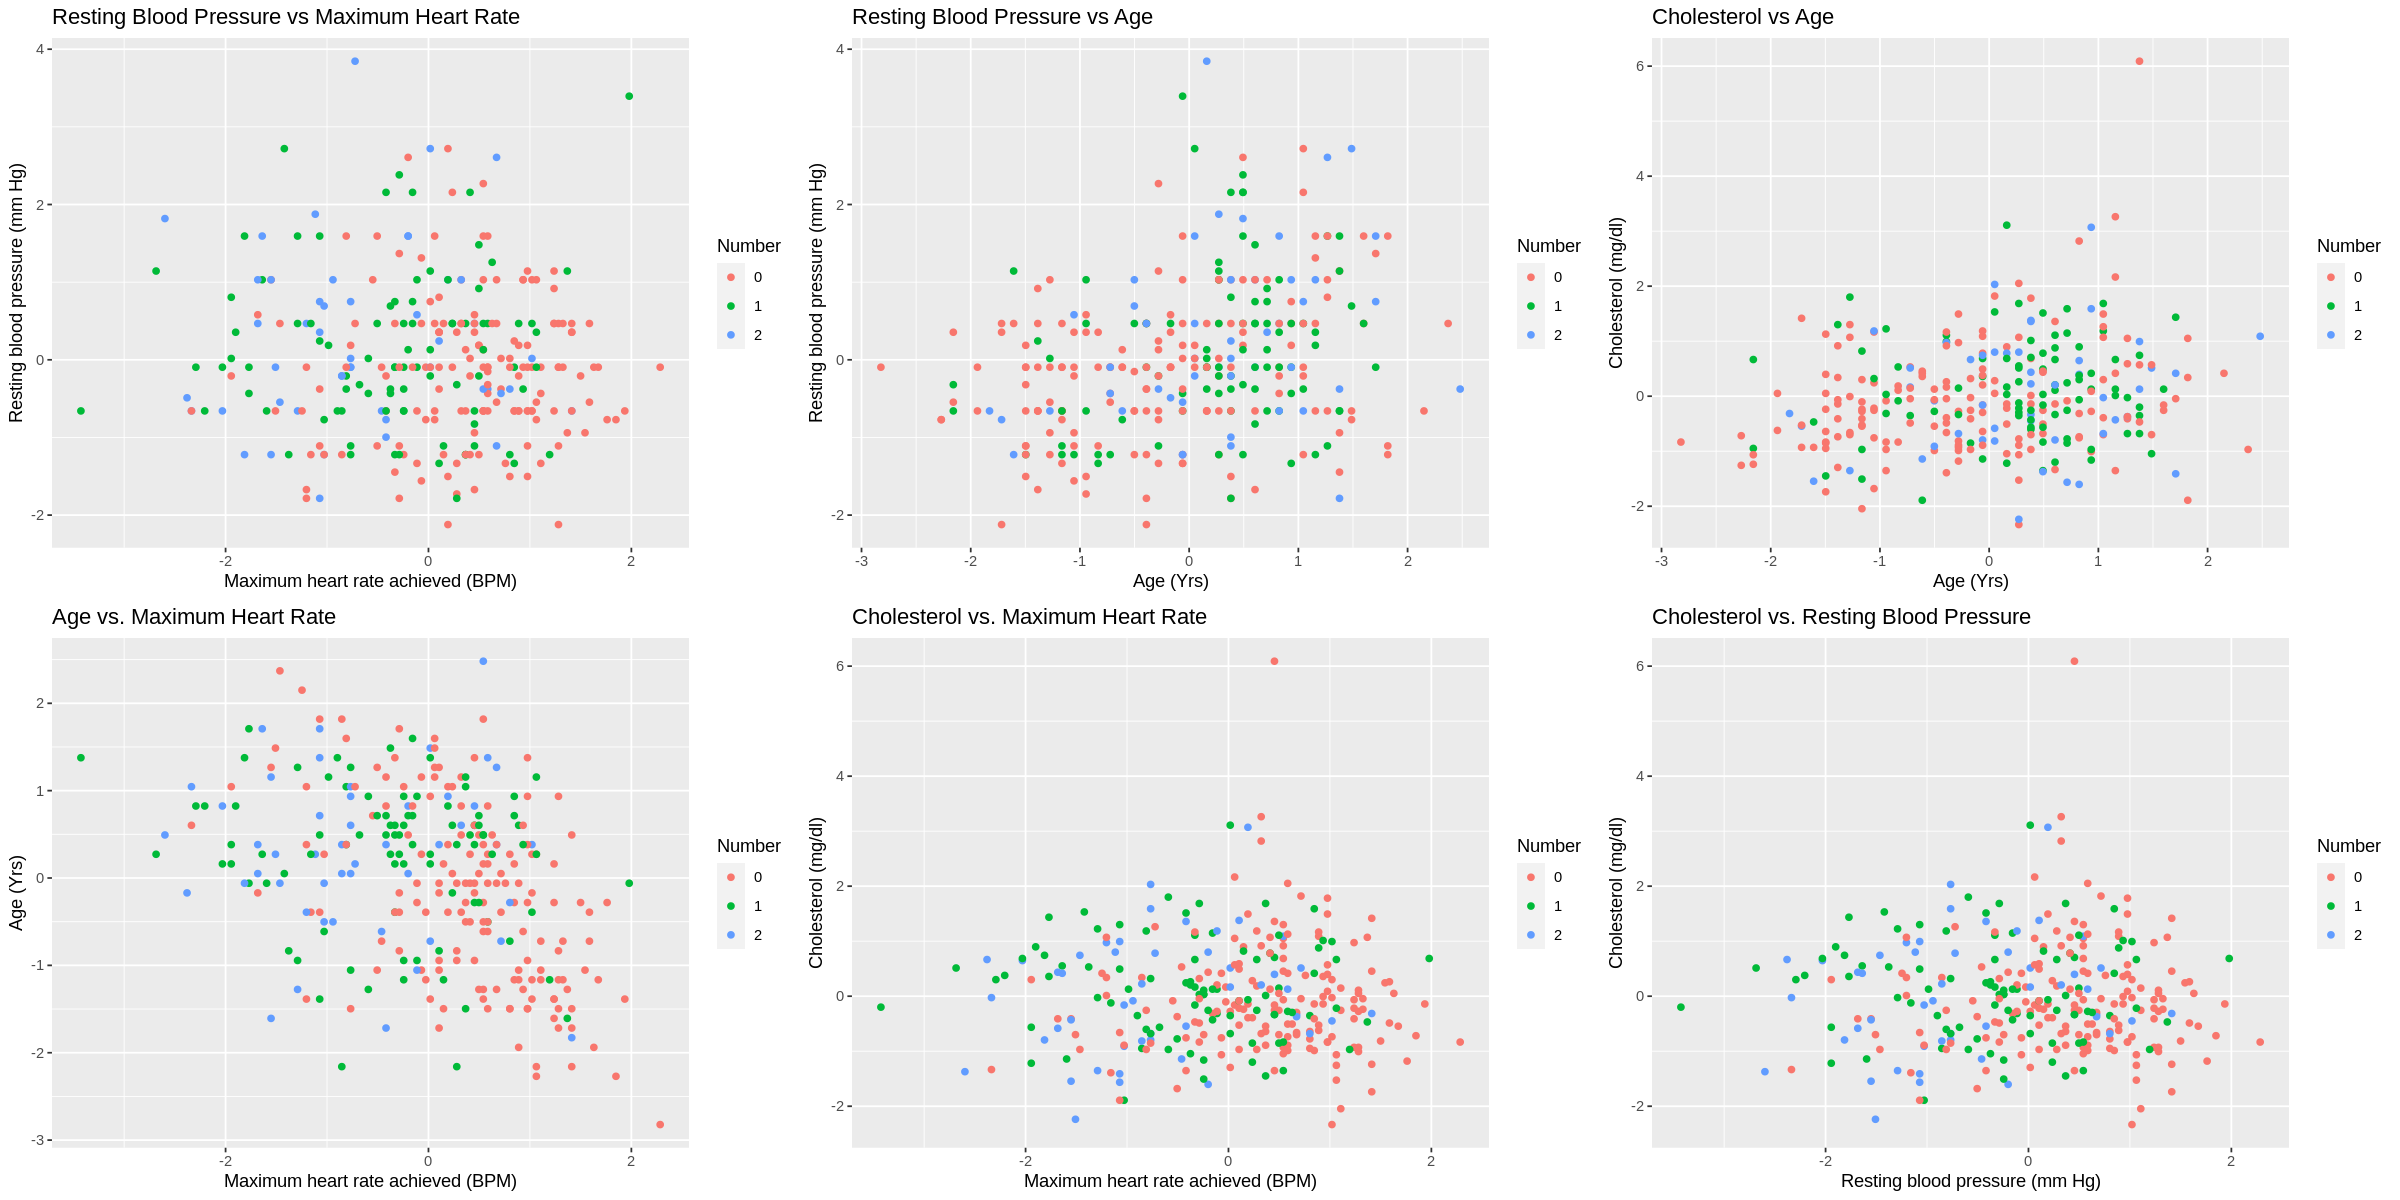

In [7]:
disease_num_viz <- mutate(scaled_heart_disease, pred = ifelse(num == 1 | num == 2, 1, ifelse(num == 3 | num == 4, 2, 0))) %>%
               select(-num)

options(repr.plot.height = 10, repr.plot.width = 20)
exp_plot_num1<-ggplot(disease_num_viz,aes(x=thalach,y=trestbps,color=as_factor(pred))) +
           geom_point() +
           xlab('Maximum heart rate achieved (BPM)') +
           ylab('Resting blood pressure (mm Hg)') +
           labs(color='Number') +
           ggtitle('Resting Blood Pressure vs Maximum Heart Rate')

exp_plot_num2<-ggplot(disease_num_viz,aes(x=age,y=trestbps,color=as_factor(pred))) +
           geom_point() +
           xlab('Age (Yrs)') +
           ylab('Resting blood pressure (mm Hg)')  +
           labs(color='Number') +
           ggtitle('Resting Blood Pressure vs Age')
exp_plot_num3<-ggplot(disease_num_viz,aes(x=age,y=chol,color=as_factor(pred))) +
           geom_point() +
           xlab('Age (Yrs)') +
           ylab('Cholesterol (mg/dl)')  +
           labs(color='Number') +
           ggtitle('Cholesterol vs Age')
exp_plot_num4<-ggplot(disease_num_viz,aes(x=thalach,y=age,color=as_factor(pred))) +
           geom_point() +
           xlab('Maximum heart rate achieved (BPM)') +
           ylab('Age (Yrs)')  +
           labs(color='Number') +
           ggtitle('Age vs. Maximum Heart Rate')
exp_plot_num5<-ggplot(disease_num_viz,aes(x=thalach,y=chol,color=as_factor(pred))) +
           geom_point() +
           xlab('Maximum heart rate achieved (BPM)') +
           ylab('Cholesterol (mg/dl)')  +
           labs(color='Number') +
           ggtitle('Cholesterol vs. Maximum Heart Rate')
exp_plot_num6<-ggplot(disease_num_viz,aes(x=thalach,y=chol,color=as_factor(pred))) +
           geom_point() +
           xlab('Resting blood pressure (mm Hg)') +
           ylab('Cholesterol (mg/dl)')  +
           labs(color='Number') +
           ggtitle('Cholesterol vs. Resting Blood Pressure')
var_compare_num<-plot_grid(exp_plot_num1, exp_plot_num2, exp_plot_num3, exp_plot_num4, exp_plot_num5, exp_plot_num6, ncol = 3)
var_compare_num

The recategorization of the data allows for a clearer distinction between levels of heart disease diagnosis, and creates a greater visual distinction as well. This recategorization effectively creates a "no heart disease", a "medium to mild heart disease" and a "severe heart disease" category. From these plots, we can hypothesize which variables will be the best predictors of heart disease. We can see that in plots containing maximum heart rate, it leads to a noticeable division in the data, with somewhat of a transition in the middle. This also occurs with age and resting blood pressure, suggesting these too may be good predictors. On the other hand, in plots containing cholesterol levels, there is either no apparent difference, or a very slight one, along its axis, suggesting it may not possess as much predictive power.

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,pred
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,2
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


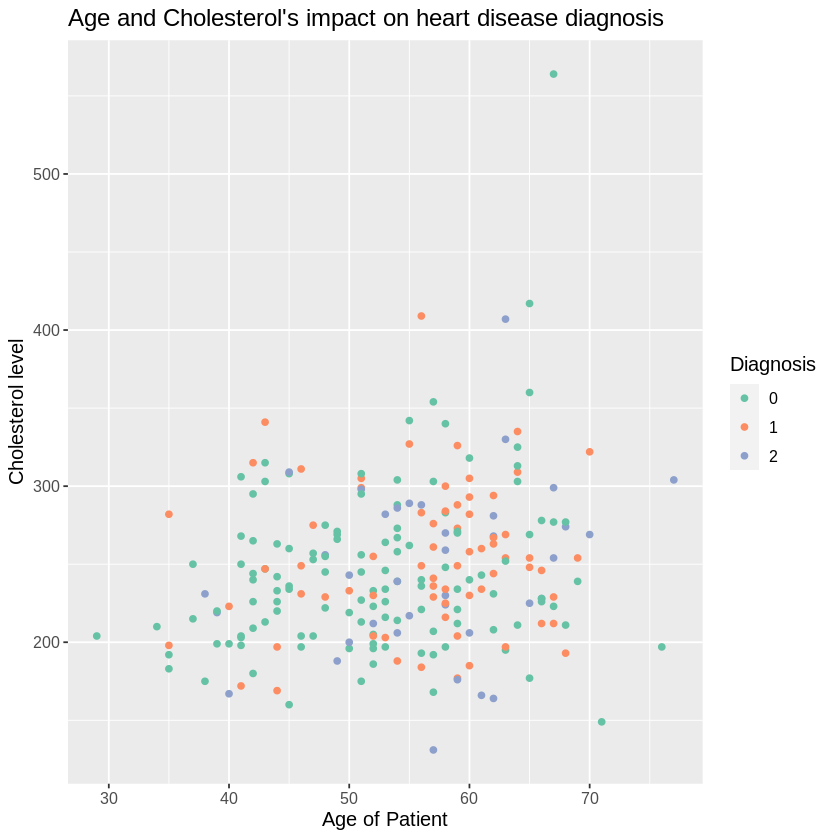

In [3]:
#splitting data into training and testing dataset
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = num)
disease_train <- training(heart_disease_split)
disease_test <- testing(heart_disease_split)

#grouping the num column for visualization clarity
disease_num <- mutate(disease_train, pred = ifelse(num == 1 | num == 2, 1, ifelse(num == 3 | num == 4, 2, 0))) %>%
               select(-num)


#creating the scattered plot
heart_disease_plot<-ggplot(disease_num, aes(x = age, y = chol, color = as_factor(pred))) +
geom_point() +
labs(x = "Age of Patient",
y = "Cholesterol level",
color = "Diagnosis") +
theme(text = element_text(size = 12)) +
ggtitle("Age and Cholesterol's impact on heart disease diagnosis")+
scale_color_brewer(palette = "Set2")



disease_num
heart_disease_plot
#123

# Methods

The main columns that will be used are age, sex, blood pressure, and cholesterol level. They will be compared to the other factors to see which ones lead to the most accurate predictions of heart disease. These comparisons will be carried out using 

We decided to create groupings of the num or predicted attributes. There were five categories originally and we combined them to create three. The first was a not at risk group which consisted of the zero category. We combined the level one and two categories to create a moderately at risk group, and the three and four levels to create an at high risk group. The not at risk group would have no risk of heart disease and would not require treatment. The moderately at risk group would have a risk of heart disease, but would not require as agressive of treatment. The highly at risk group would have a risk of heart disease and would require extensive treatment. 


# Expected Outcomes and Significance

We expect that age, sex, and blood pressure will be significant predictors of heart disease due to their creation of apparent separation in the predictive analysis. We expect that there will be a positive relationship between these predictors and occurence rate of heart disease.

Predicting which factors raise a person's likelihood for heart disease allows medical professionals to be more accurately informed and increases the chance for accurate diagnosis. As heart disease is one of the leading causes of death, early preventative and diagnostic action can lead to a decreased mortality rate.

Finally, a more accurate diagnosis of heart disease allows for more detailed research of its causes, as well as potential treatments. By prioritizing focus on those causes that play a more significant role, future research in the field may become more efficient and effective.